# Websites and brands covered in this analysis:

First, do your research and discuss how to conduct a brand analysis. Then develop an analysis on the fashion trend of underwear and swimwear products. Datasets were created by extracting data from popular retail sites via PromptCloud data extraction solutions. Sites covered are; Amazon, Victoria's Secret, Btemptd, Calvin Klein, Hanky Panky, American Eagle, Macy's, Nordstrom, Topshop USA. 

In [199]:
import io 
import sys
PATH = '/Data'
DIR_DATA = '../Data/' #.. Permite acceder la nivel /Data/
sys.path.append(PATH) if PATH not in list(sys.path) else None #Inicializa la ruta, reconozca la estructura del notebook, para 
#No salir del dominio

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#Librerías para algoritmos de Machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Librerías para visualización
import seaborn as sns
%matplotlib inline
import time


## Cargar datasets  (Retailer - Number of rows)

In [276]:
df_list=[] # Cargamos dataset, en forma de lista. 
 
start = time.time()

aerie_df = pd.read_csv(DIR_DATA + 'ae_com.csv', sep=',')
df_list.append(aerie_df)

calvin_klein_df = pd.read_csv(DIR_DATA + 'calvinklein_com.csv', sep=',')
df_list.append(calvin_klein_df)

amazon_df = pd.read_csv(DIR_DATA + 'amazon_com.csv', sep=',')
df_list.append(amazon_df)

btempted_df = pd.read_csv(DIR_DATA + 'btemptd_com.csv', sep=',')
df_list.append(btempted_df)

hanky_panky_df = pd.read_csv(DIR_DATA + 'hankypanky_com.csv', sep=',')
df_list.append(hanky_panky_df)

macys_df = pd.read_csv(DIR_DATA + 'macys_com.csv', sep=',')
df_list.append(macys_df)

nordstrom_df = pd.read_csv(DIR_DATA + 'shop_nordstrom_com.csv', sep=',')
df_list.append(nordstrom_df)

topshop_df = pd.read_csv(DIR_DATA + 'us_topshop_com.csv', sep=',')
df_list.append(topshop_df)

victoriassecret_df = pd.read_csv(DIR_DATA + 'victoriassecret_com.csv', sep=',')
df_list.append(victoriassecret_df)

end = time.time()
print("Read csv: ",(end-start),"sec")

Read csv:  6.369062185287476 sec


## Unir cada elemento de la lista en un dataframe

In [277]:
start = time.time()
df_data = pd.DataFrame() # Empty dataframe to merge brand datasets

for df in df_list:
    df_data = df_data.append(df) #Unión dataframe - En orden - Uno debajo del otro

end = time.time()
print("Unir en DF: ",(end-start),"sec")


Unir en DF:  0.6678004264831543 sec


## Limpieza de datos

### Normalizar los valores de los precios
La notación utilizada para denotar los precios varía entre los conjuntos de datos. Las columnas price y Maximum retail price (mrb) deben estar en la misma unidad. 


In [403]:
df_data.isnull().any() #Con cualquier dato nulo (True)

product_name        False
mrp                 False
price               False
pdp_url             False
brand_name          False
product_category    False
retailer            False
description         False
rating               True
review_count         True
style_attributes     True
total_sizes         False
available_size      False
color                True
product_group       False
dtype: bool

In [342]:
#Standardize price values used across datasets
import re #A regular expression (or RE) specifies a set of strings that matches it; 
#the functions in this module let you check if a particular string matches a given regular expression 

def string_matches(value_str):
    if type(value_str) is str: #Se compara que el dato analizado sea tipo string - para realizar la estandarización
        #Se eliminan espacios, convierte a minuscula, se elimina cualquier simbolo dollar. 
        value_str= value_str.strip().lower().replace('usd', '').replace('$','').replace("\-.*","").strip()
        value_str = re.sub(r"-.*", "", value_str)
        value_str = re.sub(r"–.*", "", value_str)
        value_str = re.sub(r"\s.*", "", value_str)
        value_str.strip()
    if "₡" in value_str:
        value_str = value_str.replace("₡", "").strip()
        value_str = pd.to_numeric(value_str) * colon_to_dollar_conversion_rate            
    elif "rp" in value_str:
        value_str = value_str.replace("rp", "").strip()
        value_str = pd.to_numeric(value_str) * ind_rp_to_dollar_conversion_rate                
           
        return value_str
    else:
        return value_str
    
df_data['mrp'] = df_data['mrp'].apply(extract_usd_value).apply(pd.to_numeric)
df_data['price'] = df_data['price'].apply(extract_usd_value).apply(pd.to_numeric)

## Estandarización de marcas

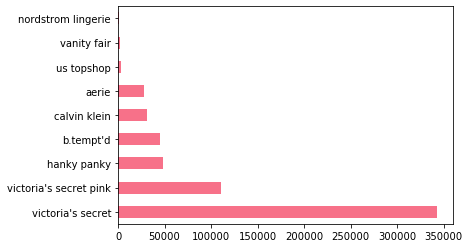

In [351]:
pd.value_counts(df_data['brand_name']).plot.barh()

In [352]:
def standardize_brand_names(brand_name):
    brand_name = brand_name.lower()
    brand_name = brand_name.replace("-", " ")
    
    if "hanky" in brand_name:
        brand_name = "hanky panky"
    elif "calvin" in brand_name:
        brand_name = "calvin klein"
    elif "wacoal" in brand_name or "tempt" in brand_name:
        brand_name = "b.tempt'd"
    elif "victorias" in brand_name:
        brand_name = "victoria's secret"
    elif "aeo" in brand_name:
        brand_name = "aerie"
    brand_name = brand_name.strip()
    return brand_name
df_data['brand_name'] = df_data['brand_name'].apply(standardize_brand_names)

In [353]:
brand_counts = pd.value_counts(df_data['brand_name'])
brand_counts

victoria's secret         342594
victoria's secret pink    110850
hanky panky                48286
b.tempt'd                  45271
calvin klein               31246
aerie                      28322
us topshop                  3081
vanity fair                 2574
nordstrom lingerie           870
Name: brand_name, dtype: int64


Nintendo, Sexy Hair, S es probable que procedan del conjunto de datos de Amazon.

##### Vemos algunas marcas con registros de un solo dígito. Tenemos que descartarlas porque no tienen datos suficientes para ser útiles.


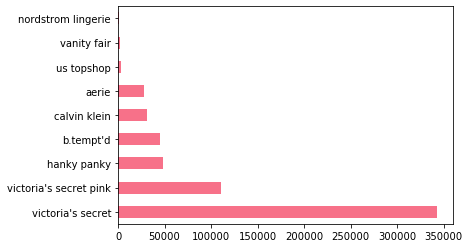

In [354]:
MIN_RECORDS = 100 #Condicionamos el numero minimos de productos por marcas para realizar la eliminación

for item in brand_counts.iteritems():
    brand = item[0] #Nombre de la marca a comparar
    count = item[1] #cantidad de productos de marca a comparar
    
    if(count < MIN_RECORDS): #Si la cantidad de productos es menor al valor establecido, no se considerará
        df_data.drop(df_data[df_data.brand_name == brand].index, inplace=True) 
        

pd.value_counts(df_data['brand_name']).plot.barh()

##### Analizando la categoría de productos, contemplamos que existen 525 categorias, las cuales representan en algunos casos la linea de producto de cada respectiva marca en particular, i.e. Un bra puede tener diferentes nombres segun la especificación y el tipo de este. 

In [355]:
product_categories = pd.value_counts(df_data['product_category'])
print(" Categorias: %d "% (product_categories.shape[0]))

 Categorias: 525 


Se organiza las categorías en grupos amplios utilizando diccionarios y palabras claves dentro de la descripción y nombre del producto.

bra                   436367
panty                 124253
lingerie               39247
top                     6077
bikini                  5775
shapewear               1019
hoodie                    93
socks                     82
leggings                  66
bottle                    39
baseball hat              27
petal                     22
kit                       18
washed canvas tote         9
Name: product_group, dtype: int64

There are 14 categories! 


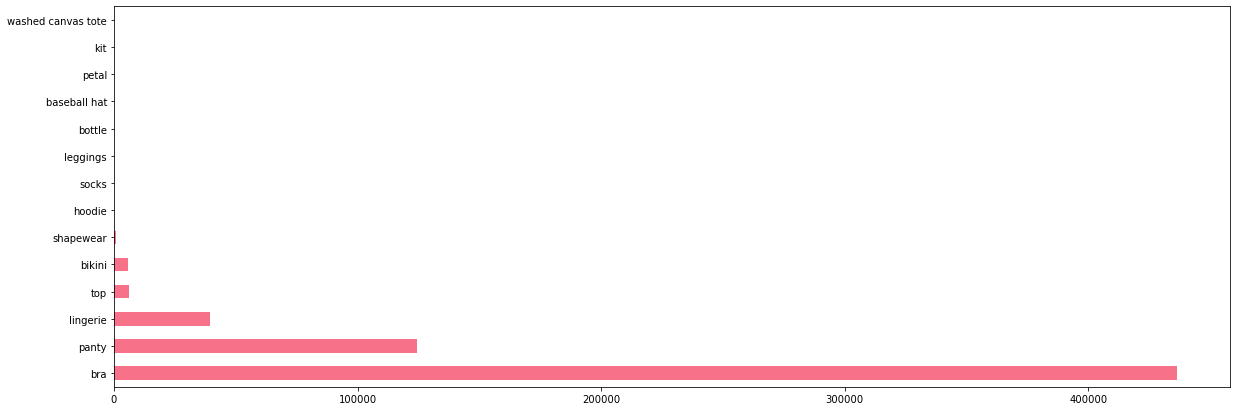

In [356]:
categories = {
    "bra" : ["bra", "push-up", "classic", "tomgirl", "collections", "longline", "bridget", "hannah", "audrey", "lorna jane", "katie", "brooke", "push", "padded", "demi", "scoop", "full coverage", "wireless", "plunge"],
    "panty" : ["panty", "panties", "brief", "hiphugger","cheekies", "thong", "hipster", "cheekster", "short", "bottom", "undies"],
    "bikini" : ["bikini", "triangle", "one-piece", "one piece", "high-neck", "hineck"],
    "top" : ["tee", "top", "tank", "halter", "bandeau", "racerback", "cami", "crop"],
    "lingerie": ["slip", "garter", "babydoll", "lingerie", "teddy", "sleepwear", "fishnet", "robe", "kimono", "bodysuit", "romper", "tunic"],
    "shapewear": ["shapewear", "bustier"],
    "socks" : ["sock"],
    "leggings": ["legging"],
    "bottle": ["bottle"],
    "hoodie" : ["full-zip"],
    "kit" : ["kit", "duffle"],
    "petal": ["petal"]
    
}

def standardize_product_category(row):
    product_category = row["product_category"]
    product_name = row["product_name"]
    
    product_name = product_name.lower()
    product_category = product_category.lower()
    
    for group, items in categories.items():
        for item in items:
            if item in product_category: #if
                return group

    for group, items in categories.items():
        for item in items:
            if item in product_name: #elseif
                return group

    return product_category #else

        

df_data["product_group"] = df_data.apply(standardize_product_category, axis=1)

product_group = pd.value_counts(df_data['product_group'])
display(product_group)
print("There are %d categories! "% (product_group.shape[0]))



fig,ax = plt.subplots(figsize=(20,7))
ax = pd.value_counts(df_data['product_group']).plot.barh()
plt.show()

#### Algunas de las categorías tienen menos de 100 artículos. Estas categorías no tienen datos suficientes para realizar una comparación eficaz.

In [362]:

MIN_RECORDS = 100

for item in product_group.iteritems():
    category = item[0]
    count = item[1]
    
    if(count < MIN_RECORDS):
        df_data.drop(df_data[df_data.product_group == category].index, inplace=True)   
product_group = pd.value_counts(df_data['product_group'])

display(product_group)

bra          436140
panty        124123
lingerie      39141
top            6069
bikini         5768
shapewear      1016
Name: product_group, dtype: int64

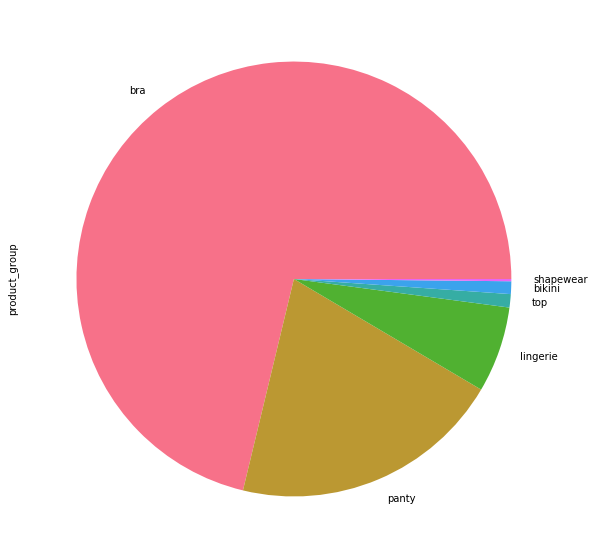

In [392]:
fig,ax = plt.subplots(figsize=(20,10))
ax = product_group.plot.pie()
plt.show()

## ¿Cómo difiere el precio según la marca?

In [408]:
df_data.isnull().any() #Con cualquier dato nulo (True)

product_name        False
mrp                 False
price               False
pdp_url             False
brand_name          False
product_category    False
retailer            False
description         False
rating               True
review_count         True
style_attributes     True
total_sizes         False
available_size      False
color                True
product_group       False
dtype: bool

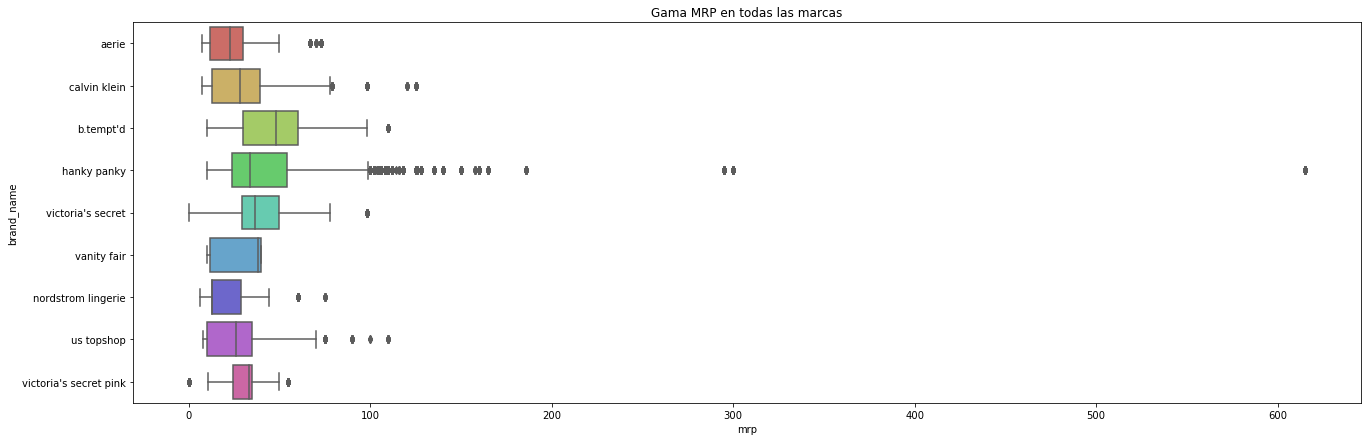

In [414]:
fig,ax = plt.subplots(figsize=(22,7))
ax = sns.boxplot( x=merged_df["mrp"], y=merged_df["brand_name"], palette = "hls").set_title('Gama MRP en todas las marcas')

plt.show()


Vanity Fair es la marca de lencería más asequible
La mayoría de las prendas de lencería pueden comprarse por un precio medio de unos 30-40 dólares y con un precio máximo de 200 dólares. Hanky Panky tiene la lencería más cara. Hay artículos que tienen un precio de 600 USD.

In [421]:
df_data[df_data["mrp"] > 200]

,product_name,mrp,price,pdp_url,brand_name,product_category,retailer,description,rating,review_count,style_attributes,total_sizes,available_size,color,product_group
5,30 Pack Original Rise Thongs in Lucite Jar,615.0,615.0,http://www.hankypanky.com/thongs/30-pack-origi...,hanky panky,Thongs,Hankypanky US,For the ultimate Hanky Panky collector! This l...,NaN,NaN,"[""One-size thong in our signature stretch lace...","[""Select"", ""One Size""]","[""Select"", ""One Size""]",Rainbow,panty
101,30 Pack Original Rise Thongs in Lucite Jar,615.0,615.0,http://www.hankypanky.com/collections/30-pack-...,hanky panky,Collections,Hankypanky US,For the ultimate Hanky Panky collector! This l...,NaN,NaN,"[""One-size thong in our signature stretch lace...","[""Select"", ""One Size""]","[""Select"", ""One Size""]",Rainbow,bra
367,30 Pack Low Rise Thongs in Lucite Jar,615.0,615.0,http://www.hankypanky.com/thongs/30-pack-low-r...,hanky panky,Thongs,Hankypanky US,For the ultimate Hanky Panky collector! This l...,NaN,NaN,"[""One-size thong in our signature stretch lace...","[""Select"", ""One Size""]","[""Select"", ""One Size""]",Rainbow,panty
949,Lady Catherine Robe,295.0,295.0,http://www.hankypanky.com/collections/lady-cat...,hanky panky,Collections,Hankypanky US,You'll look like a princess in Lady Catherine.,NaN,NaN,"[""Silk robe "", "" Features eyelash lace at edge...","[""Select"", ""Petite Small"", ""M-L""]","[""Select"", ""Petite Small"", ""M-L""]",Black,bra
950,Lady Catherine Robe,295.0,295.0,http://www.hankypanky.com/collections/lady-cat...,hanky panky,Collections,Hankypanky US,You'll look like a princess in Lady Catherine.,NaN,NaN,"[""Silk robe "", "" Features eyelash lace at edge...","[""Select"", ""Petite Small"", ""M-L""]","[""Select"", ""Petite Small"", ""M-L""]",Light Ivory,bra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33667,Original Rise Thong Rose Bouquet of 12,300.0,300.0,http://www.hankypanky.com/thongs/original-rise...,hanky panky,Thongs,Hankypanky US,Give the gift that lasts as long as your love ...,NaN,NaN,"[""One-size thong in our signature stretch lace...","[""One Size""]","[""One Size""]",Red,panty
34206,30 Pack Low Rise Thongs in Lucite Jar,615.0,615.0,http://www.hankypanky.com/thongs/30-pack-low-r...,hanky panky,Thongs,Hankypanky US,For the ultimate Hanky Panky collector! This l...,NaN,NaN,"[""One-size thong in our signature stretch lace...","[""One Size""]","[""One Size""]",Rainbow,panty
34895,Lady Catherine Robe,295.0,295.0,http://www.hankypanky.com/collections/lady-cat...,hanky panky,Collections,Hankypanky US,You'll look like a princess in Lady Catherine.,NaN,NaN,"[""Silk robe "", "" Features eyelash lace at edge...","[""Petite Small"", ""M-L""]","[""Petite Small"", ""M-L""]",Black,bra
34896,Lady Catherine Robe,295.0,295.0,http://www.hankypanky.com/collections/lady-cat...,hanky panky,Collections,Hankypanky US,You'll look like a princess in Lady Catherine.,NaN,NaN,"[""Silk robe "", "" Features eyelash lace at edge...","[""Petite Small"", ""M-L""]","[""Petite Small"", ""M-L""]",Light Ivory,bra


Resulta que todos son paquetes de 30 tangas. Lo que hace que cada prenda de ropa interior cueste alrededor de 20 dólares. 

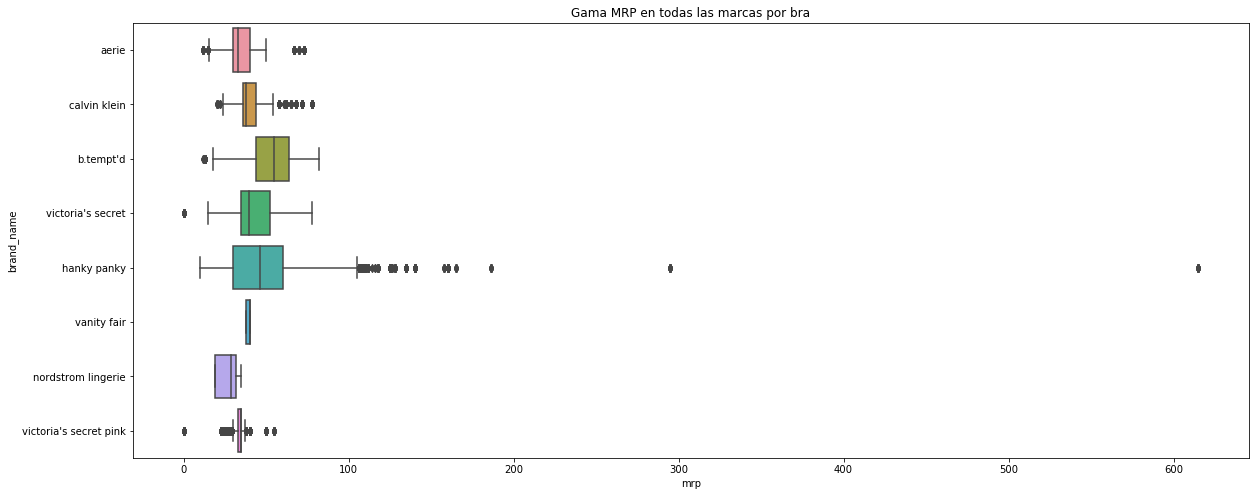

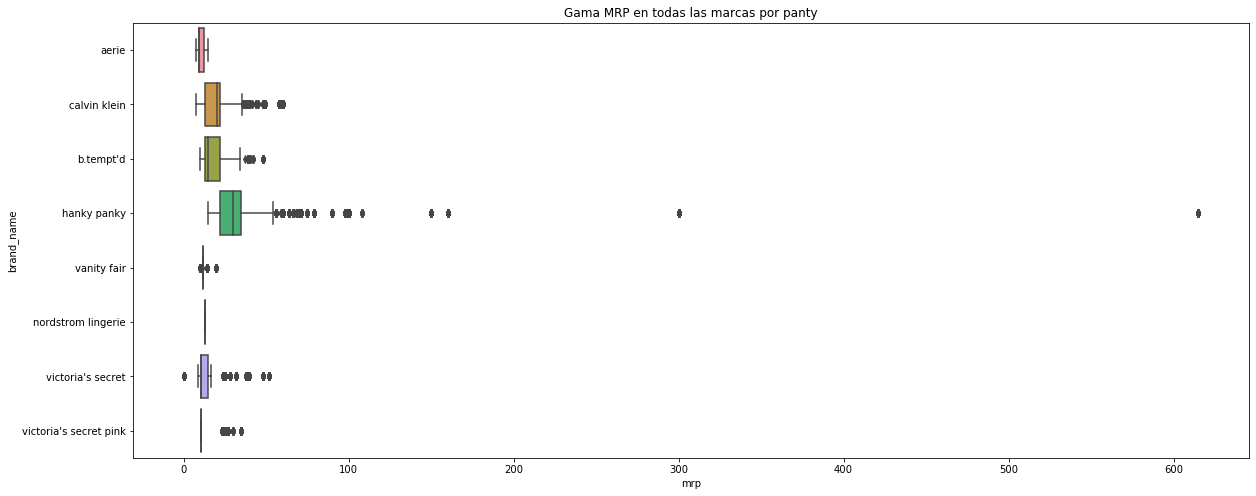

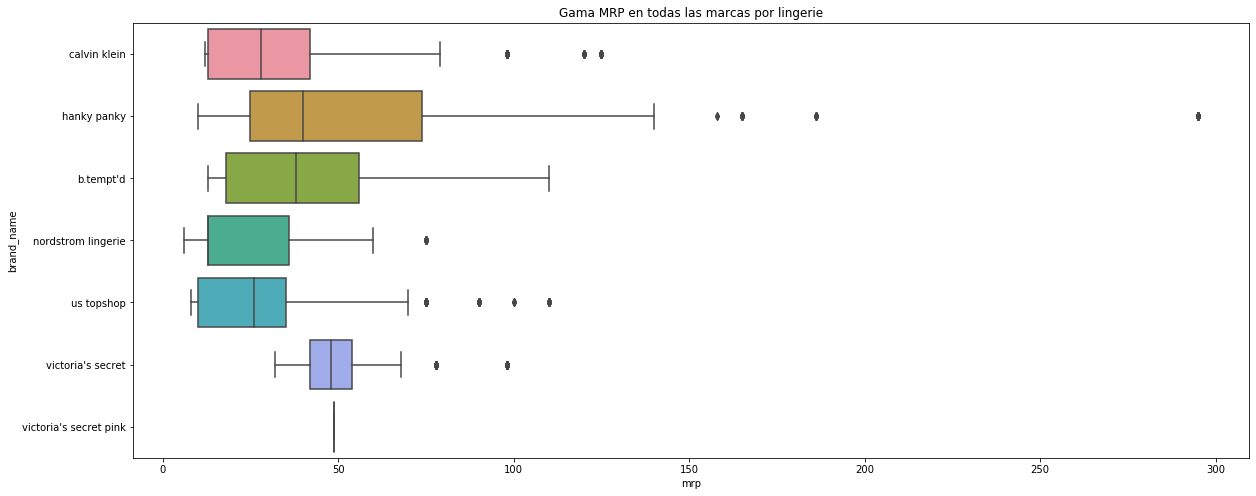

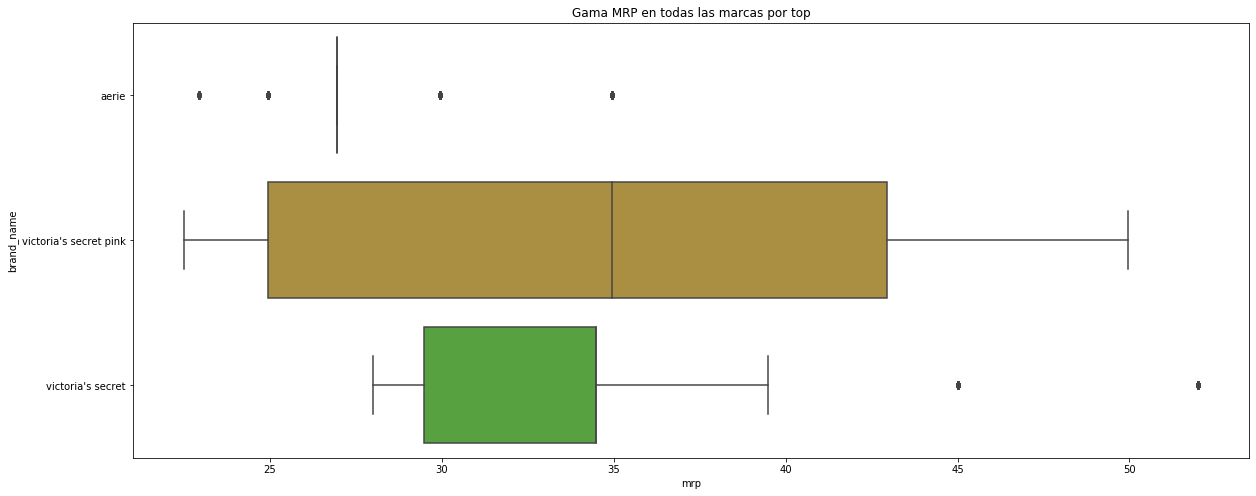

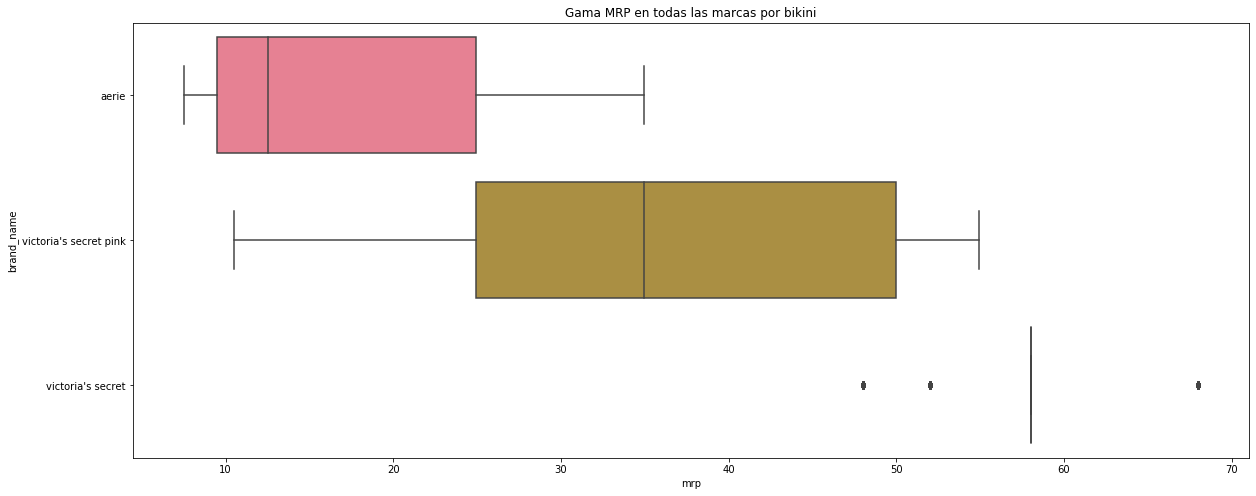

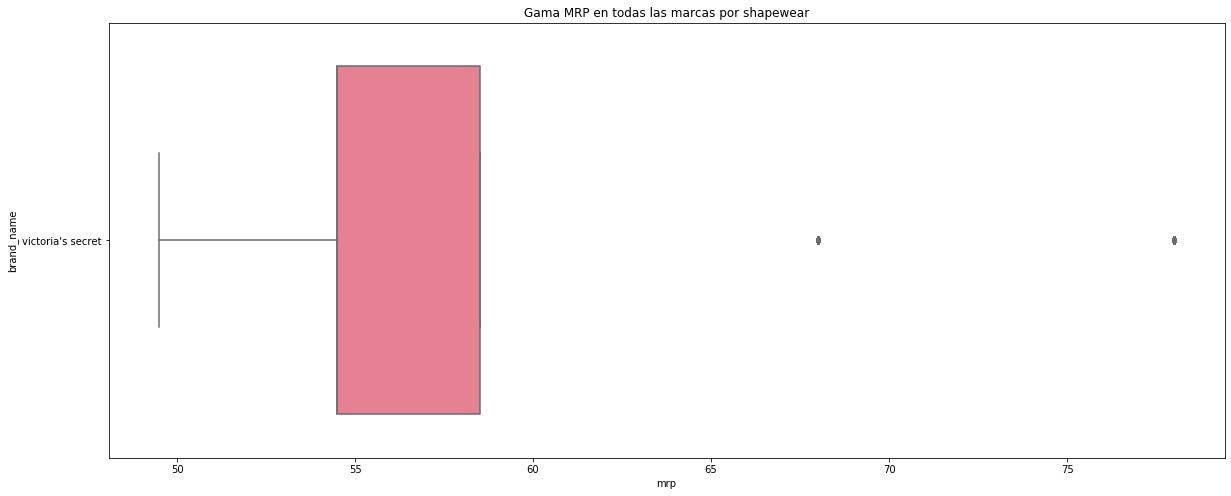

In [522]:
import matplotlib as plt
from matplotlib import *

product_group = pd.value_counts(df_data['product_group'])

for item in product_group.iteritems():
    category = item[0]
    
    product_group_df = df_data[df_data["product_group"] == category]
    

    
    pyplt.figure(figsize=(20, 8))
    title = "Gama MRP en todas las marcas por "+ category 
    sns.boxplot( x="mrp", y="brand_name", data=product_group_df).set_title(title)


Aquí la mayor competencia se da entre los brasieres y las pantaletas. En este conjunto de datos no hay mucha elección en cuanto a la ropa interior. Todas las marcas parecen tener rangos de precios bastante comparables para los brasieres y las pantaletas. Hanky Panky tiene algunos artículos más caros, sin incluir el paquete de 20/30 de ropa interior

## What are the most common color used by different brands?

In [493]:
 pd.value_counts(df_data["color"])

Black                       36913
White                       18068
black                       13121
pure black                   7083
Ensign                       6738
                            ...  
All Over Lace Shock Pink        1
Gray Colorblock                 1
Black Coffee                    1
Flash                           1
BLUE PULSE                      1
Name: color, Length: 2528, dtype: int64

In [501]:
categories = {
    "green" : ["green", "emerald", "fir", "bayberry"],
    "blue" : ["blue", "navy", "teal", "denim", "azure", "celeste", "turkish", "sea"],
    "white" : ["white", "ivory", "cashew", "coconut", "marshmallow"],
    "black" : ["black", "midnight", "night"],
    "red": ["red", "candy apple", "ginger glaze", "plum", "maroon", "ruby","cherry", "strawberry"],
    "yellow": ["yellow", "gold"],
    "orange" : ["orange"],
    "pink": ["pink", "rosewater", "fuschia", "blush", "peach", "lotus"],
     "nude" : ["nude", "bare", "champagne"],
    "gray" : ["gray", "grey", "pewter", "slate", "silver"],
    "brown" : ["brown", "taupe", "chai", "cappuccino", "sienna", "toast", "french roast"],
    "maroon" : ["maroon"],
    "purple" : ["mauve", "lilac", "purple", "violet", "grape"]
    
}

def standardize_color_group(color):
    color_category = color
    
    try:
        color_category = color_category.lower()

        for group, items in categories.items():
            for item in items:
                if item in color_category:
                    return group
    except:
        print(color_category)
        
    return color_category

df_data['color'] = df_data['color'].fillna('unknown')
df_data["color_group"] = df_data['color'].apply(standardize_color_group)

color_group = pd.value_counts(df_data['color_group'])
display(color_group)
print("There are %d categories! "% (color_group.shape[0]))
color_group.to_csv('color_mania.csv')


black                       115227
white                        69733
blue                         52789
pink                         51950
red                          42730
                             ...  
astonish                         1
neon calypso                     1
null                             1
peacoat/polka dot accent         1
tanimal all over lace            1
Name: color_group, Length: 834, dtype: int64

There are 834 categories! 


<ipython-input-501-713bab8ffd8f>:39: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  color_group.to_csv('color_mania.csv')


## El color que mayor uso tiene sin importar la marca es el negro con 115.227

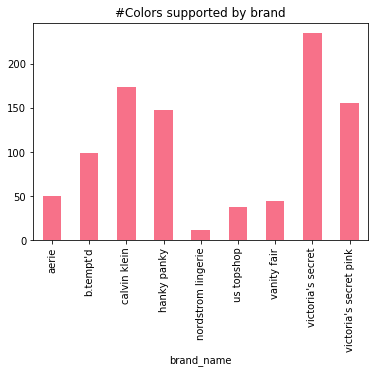

In [496]:
df_data.groupby(["brand_name"])["color_group"].nunique().plot.bar(title='#Colors supported by brand')

Text(0.5, 0, '#colors per product type')

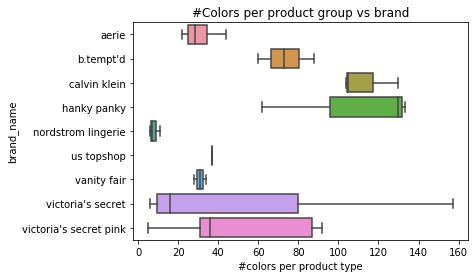

In [497]:
color_count_df = df_data.groupby(["brand_name", "product_group"]).color_group.nunique()
color_count_df = color_count_df.reset_index()
plot = sns.boxplot(x='color_group', y='brand_name', data=color_count_df)
plot.set_title("#Colors per product group vs brand")
plot.set_xlabel('#colors per product type')

Text(0, 0.5, '#colors for product group')

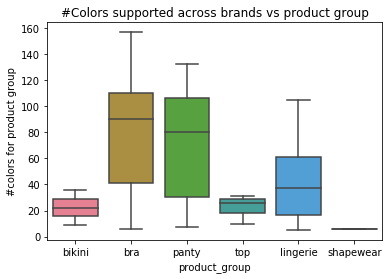

In [498]:
plot = sns.boxplot(x='product_group', y='color_group', data=color_count_df)
plot.set_title("#Colors supported across brands vs product group")
plot.set_ylabel('#colors for product group')

## What are the ratings like across brands ?

In [503]:
pd.value_counts(df_data['rating'])

4.4    37103
4.3    29563
4.5    25065
5.0    20133
4.2    17798
4.0    17781
4.6    13444
4.7     8820
3.7     8673
3.9     8033
4.1     7790
3.8     7504
4.8     6741
3.6     5060
3.2     4300
4.9     3380
3.3     2827
3.5     2471
3.0     2133
1.0     1184
2.0      509
3.1      503
3.4      459
2.9      448
2.8      360
2.6      339
2.5      244
2.7      161
1.5      160
0.0      124
2.4       52
2.3       34
2.2        8
2.1        8
1.7        8
Name: rating, dtype: int64

Text(0, 0.5, 'Brand')

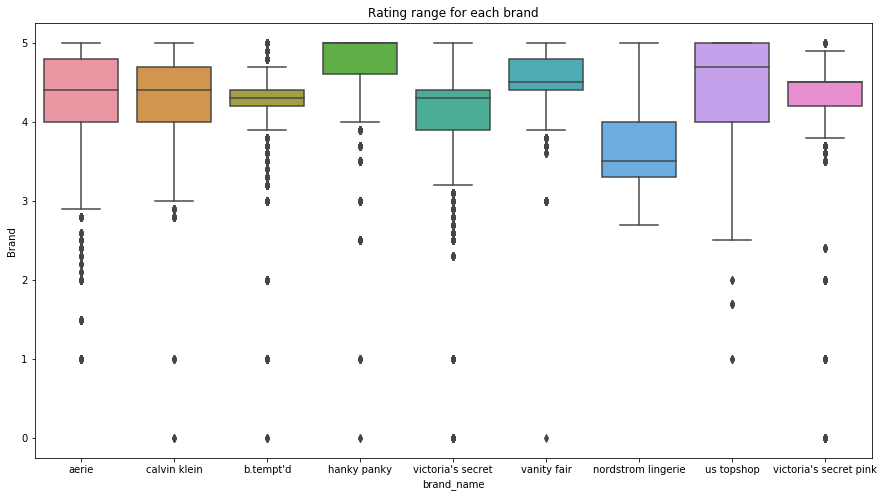

In [505]:
pyplt.figure(figsize=(15,8))
plot = sns.boxplot(x='brand_name', y='rating', data=df_data)
plot.set_title("Rating range for each brand")
plot.set_ylabel('Brand')

## La lencería de Nordstrom no está bien valorada aquí. Victoria's Secret parece tener una puntuación más baja que marcas como Hanky Panky. Sin embargo, también tiene un inventario muy grande, en comparación con otras marcas, lo que podría sesgar los resultados. A primera vista, me inclino por comprar en Hanky Panky en lugar de otras marcas.

In [ ]:
product_group = pd.value_counts(merged_df['product_group'])

for item in product_group.iteritems():
    category = item[0]
    
    product_group_df = merged_df[merged_df["product_group"] == category]
    plt.pyplot.figure()
    title = "Ratings range across brands for "+ category 
    sns.boxplot( x=product_group_df["rating"], y=product_group_df["brand_name"], palette = "Pastel2").set_title(title)

## Hanky Panky parece muy bien valorada incluso entre las categorías de bragas y sujetadores. Algunas sorpresas fueron Aerie y Calvin Klein, que parecen hacerlo ligeramente mejor que Victoria Secrets.

## Multivariate analysis

Text(0.5, 0.98, 'Análisis de correlación entre las variables')

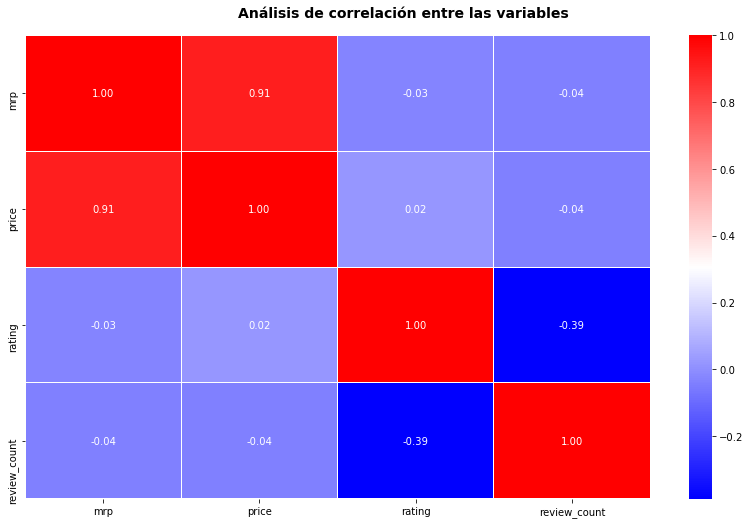

In [553]:
fig, (ax) = pyplt.subplots(1, 1, figsize=(14,8)) 
hm = sns.heatmap(df_data.corr(), ax=ax, cmap="bwr", annot=True, fmt='.2f', linewidths=.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Análisis de correlación entre las variables', fontsize=14, fontweight='bold')

In [ ]:
sns.pairplot(df_data, hue = 'product_group')

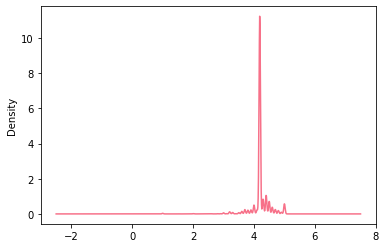

In [614]:
vf_rating = pd.value_counts(df_data['rating'])
vf_rating
rating_mean = df_data.rating.drop(df_data[df_data['rating']== 'unknown'].index).mean()
df_data['rating'] = df_data['rating'].replace('unknown',rating_mean)
df_data['rating'].plot.kde()

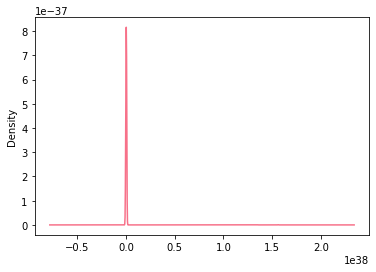

In [625]:
vf_view = pd.value_counts(df_data['review_count'])
x = df_data.review_count.dropna()
df_data.review_count = df_data.review_count.fillna(x.mean())

df_data.review_count.plot.kde()


In [629]:
scaler = StandardScaler()
scaled = scaler.fit_transform(
    df_data[['price', 'mrp', 'rating', 'review_count']].values
    )
scaled
covariance_matrix = np.cov(scaled.T)
covariance_matrix


array([[ 1.00000163,  0.91495969,  0.01414394, -0.02131683],
       [ 0.91495969,  1.00000163, -0.01542501, -0.0214555 ],
       [ 0.01414394, -0.01542501,  1.00000163, -0.37321018],
       [-0.02131683, -0.0214555 , -0.37321018,  1.00000163]])

In [630]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [631]:
eigen_values


array([1.91613039, 0.08446702, 0.62682128, 1.37258785])

In [632]:
eigen_vectors

array([[ 0.70660715,  0.70665395, -0.03145344,  0.01890019],
       [ 0.706369  , -0.7069371 ,  0.00726043,  0.03507225],
       [ 0.01493099, -0.02743233, -0.70602007, -0.70750279],
       [-0.03906713, -0.01129623, -0.70745575,  0.70558665]])

In [634]:
variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[47.90318140743302, 2.111672073927358, 15.67050632741602, 34.314640191223624]


  ## Las dos variables que guardan mayor covarianza son  ['price' , 'review_count]

In [710]:
df_data.columns
X = df_data.drop(['product_name', 'pdp_url', 'brand_name','product_category', 'retailer', 'description', 'style_attributes', 'total_sizes', 'available_size', 'color', 'product_group', 'color_group','target'], axis=1)
print(X.shape)
X

(612257, 4)


,mrp,price,rating,review_count
0,12.5,12.5,5.0000,8.000000e+00
1,12.5,12.5,5.0000,8.000000e+00
2,12.5,12.5,5.0000,8.000000e+00
3,12.5,12.5,5.0000,8.000000e+00
4,12.5,12.5,5.0000,8.000000e+00
...,...,...,...,...
453381,48.0,48.0,4.1883,5.716612e+35
453382,48.0,48.0,4.1883,5.716612e+35
453383,48.0,48.0,4.1883,5.716612e+35
453384,48.0,48.0,4.1883,5.716612e+35


Text(0, 0.5, 'Brand')

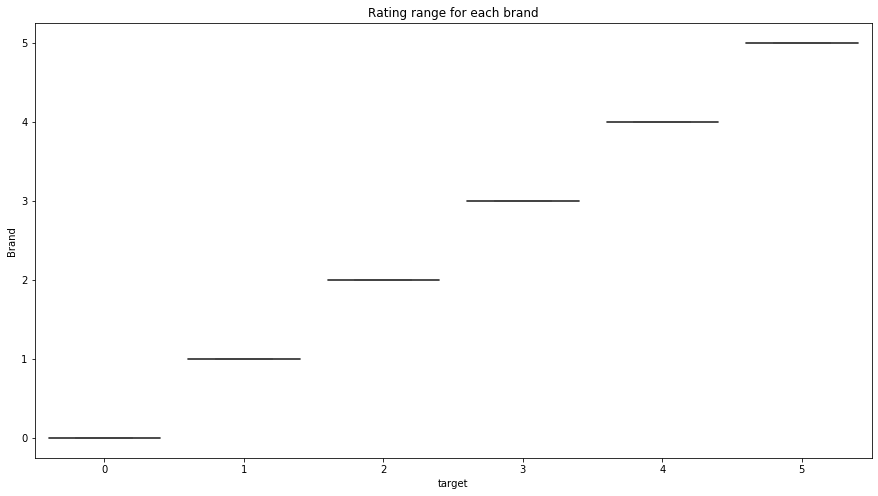

In [711]:
# Creating a instance of label Encoder.
le = LabelEncoder()
target = le.fit_transform(df_data['product_group'])
df_data['product_group'] = target
pyplt.figure(figsize=(15,8))
plot = sns.boxplot(x='target', y='product_group', data=df_data)
plot.set_title("Rating range for each brand")
plot.set_ylabel('Brand')

array([0, 0, 0, ..., 7, 7, 7])

# Split the dataset into a training set and a testing set
## Advantages
- By splitting the dataset pseudo-randomly into a two separate sets, we can train using one set and test using another.
- This ensures that we won't use the same observations in both sets.
- More flexible and faster than creating a model using all of the dataset for training.
## Disadvantages
- The accuracy scores for the testing set can vary depending on what observations are in the set.
- This disadvantage can be countered using k-fold cross-validation.

In [720]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.7, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(183677, 4)
(183677,)
(428580, 4)
(428580,)


In [721]:
# Instantiating LinearRegression() Model
lr = LinearRegression()

In [722]:
# Training/Fitting the Model
lr.fit(X_train, y_train)

LinearRegression()

In [723]:
# Making Predictions
lr.predict(X_test)
pred = lr.predict(X_test)

# Evaluating Model's Performance
print('Mean Absolute Error:', mean_absolute_error(y_test, pred))
print('Mean Squared Error:', mean_squared_error(y_test, pred))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.7472144041698283
Mean Squared Error: 0.8011806640595541
Mean Root Squared Error: 0.8950869589372611


In [685]:
df_data.head(30)

,product_name,mrp,price,pdp_url,brand_name,product_category,retailer,description,rating,review_count,style_attributes,total_sizes,available_size,color,product_group,color_group,target
0,Aerie Everyday Loves Lace Cheeky,12.5,12.5,https://www.ae.com/aerie-everyday-loves-lace-c...,aerie,Cheekies,Ae US,Introducing Everyday Loves™: Made with love. E...,5.0000,8.000000e+00,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]",Rugged Green,panty,green,3
1,Aerie Everyday Loves Lace Cheeky,12.5,12.5,https://www.ae.com/aerie-everyday-loves-lace-c...,aerie,Cheekies,Ae US,Introducing Everyday Loves™: Made with love. E...,5.0000,8.000000e+00,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]",Natural Nude,panty,nude,3
2,Aerie Everyday Loves Lace Cheeky,12.5,12.5,https://www.ae.com/aerie-everyday-loves-lace-c...,aerie,Cheekies,Ae US,Introducing Everyday Loves™: Made with love. E...,5.0000,8.000000e+00,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]",True Black,panty,black,3
3,Aerie Everyday Loves Lace Cheeky,12.5,12.5,https://www.ae.com/aerie-everyday-loves-lace-c...,aerie,Cheekies,Ae US,Introducing Everyday Loves™: Made with love. E...,5.0000,8.000000e+00,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]",White,panty,white,3
4,Aerie Everyday Loves Lace Cheeky,12.5,12.5,https://www.ae.com/aerie-everyday-loves-lace-c...,aerie,Cheekies,Ae US,Introducing Everyday Loves™: Made with love. E...,5.0000,8.000000e+00,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]",Royal Navy,panty,blue,3
5,Aerie Everyday Loves Lace Cheeky,12.5,12.5,https://www.ae.com/aerie-everyday-loves-lace-c...,aerie,Cheekies,Ae US,Introducing Everyday Loves™: Made with love. E...,5.0000,8.000000e+00,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]",Slab Gray,panty,gray,3
6,Aerie Lace Hi-Rise Boybrief,12.5,12.5,https://www.ae.com/undies-aerie-lace-hi-rise-b...,aerie,Boybriefs,Ae US,Laced with love and extra comfort. No cheek pe...,4.8000,5.716612e+35,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L""]",White,panty,white,3
10,Aerie Lace Hi-Rise Boybrief,12.5,12.5,https://www.ae.com/undies-aerie-lace-hi-rise-b...,aerie,Boybriefs,Ae US,Laced with love and extra comfort. No cheek pe...,4.8000,5.716612e+35,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M""]",Stone,panty,stone,3
11,Aerie Lace Hi-Rise Boybrief,12.5,12.5,https://www.ae.com/undies-aerie-lace-hi-rise-b...,aerie,Boybriefs,Ae US,Laced with love and extra comfort. No cheek pe...,4.8000,5.716612e+35,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M"", ""L"", ""XL""]",Deep Plum,panty,red,3
12,Aerie Lace Hi-Rise Boybrief,12.5,12.5,https://www.ae.com/undies-aerie-lace-hi-rise-b...,aerie,Boybriefs,Ae US,Laced with love and extra comfort. No cheek pe...,4.8000,5.716612e+35,"[""Soft lace with the right amount of stretch"",...","[""XS"", ""S"", ""M"", ""L"", ""XL"", ""XXL""]","[""XS"", ""S"", ""M""]",Royal Navy,panty,blue,3


In [724]:
d = {'Price' : [9.5],
     'rating' : [4.5],
    'View' : [2.0],
    'Product_group' : 0} #Panty
test_df = pd.DataFrame(data= d)
test_df

,Price,rating,View,Product_group
0,9.5,4.5,2.0,0


In [730]:
test = test_df.iloc[0:1,:4]
test

,Price,rating,View,Product_group
0,9.5,4.5,2.0,0


In [731]:
pred = lr.predict(test)
print('Tipo de ropa', pred[0])
print('Ropa actual', 0)

Tipo de ropa 1.5045168201902428
Ropa actual 0
